In [1]:
%pylab inline
import scipy.io as sio
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


#Exploring the data
First I load the data and print it out to see its structure.
Then I plot the output of the channels. From the plot I can see that the 3rd and 37th channel does not provide useful information about the seizure so I cut them out from the 'adat' array.

In [2]:
data=sio.loadmat('Seizure1')
data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Sep 01 19:13:34 2014',
 '__version__': '1.0',
 'adat': array([[-16,  -4, -81, ...,  82,  54,  41],
        [-17,  -5, -80, ...,  81,  54,  41],
        [-17,  -4, -81, ...,  80,  54,  41],
        ...,
        [ 36,  25,   6, ...,  -6,  17,  12],
        [ 35,  24,   6, ...,  -4,  17,  13],
        [ 34,  24,   6, ...,  -2,  17,  13]], dtype=int16)}

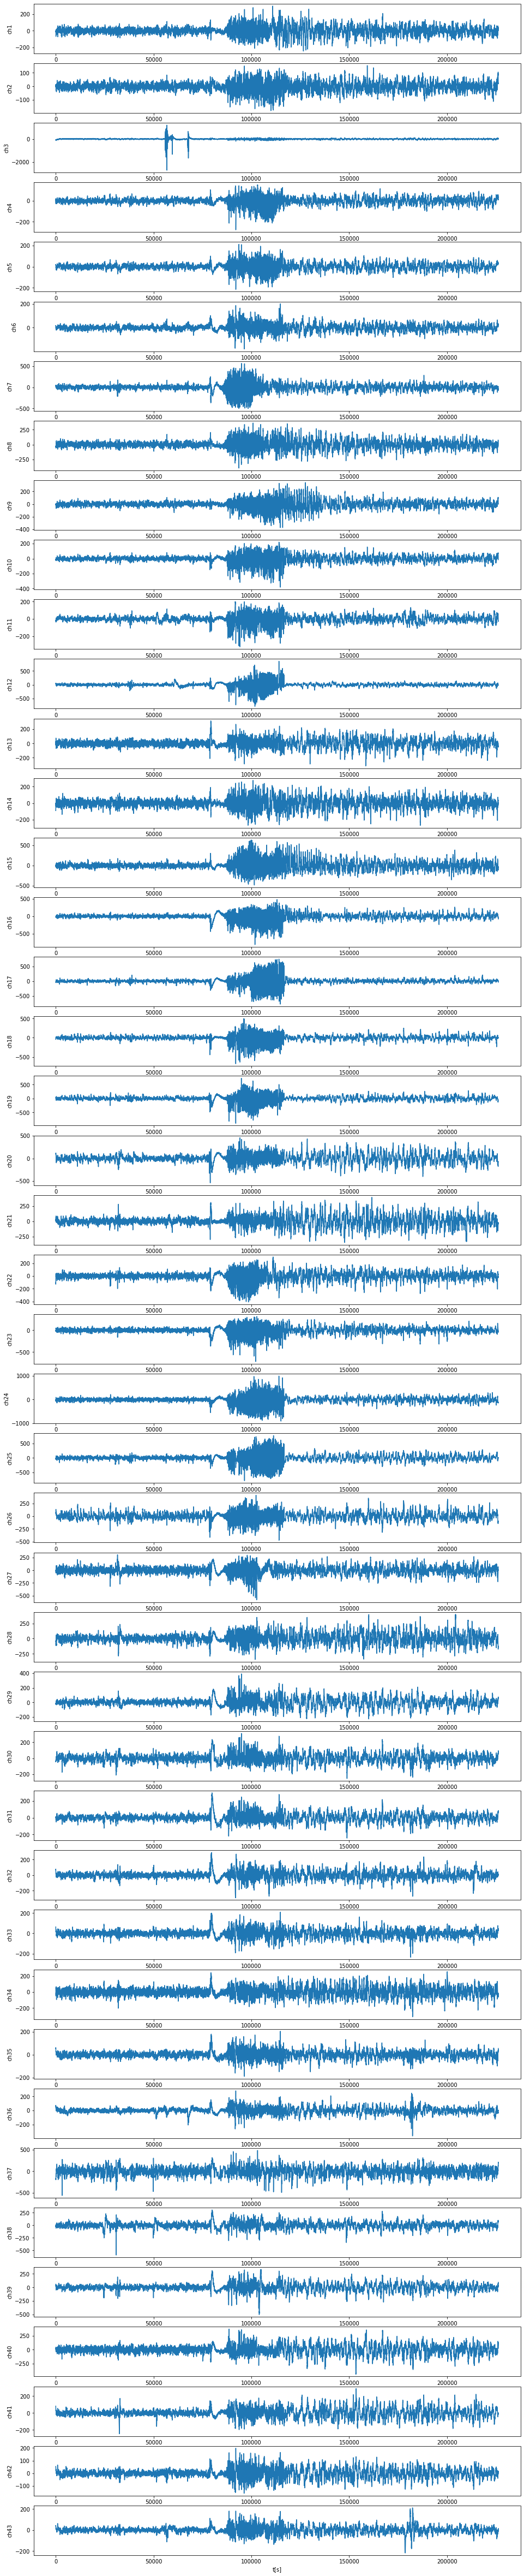

In [3]:
# plotting
figure(figsize=(16,86))

for i in range(43):
    subplot(43,1,i+1)
    plot(data['adat'][:,i])
    ylabel('ch'+str(i+1))
    xlabel('t[s]')

In [3]:
#deleting the 3rd and 37th channel from the dataset
data_cut = np.delete(data['adat'], 36, axis=1)
data_cut = np.delete(data_cut, 2, axis=1)

 I divide the data into three parts. From 0-75s (before the seizure), from 75-120s (seizure), and from 120s to the end (after seizure), since later it might be useful.

In [4]:
#dividing data
before=data_cut[0:75000,:]
seizure=data_cut[75000:120000,:]
after=data_cut[120000:,:]

#ARMA model fitting

I used the built-in ARMA model fitting function of the statsmodels library. Since the runtime of the fitting was very high, I could not generate a lot of different models of different order in a for cicle like in the example code. I did however changed the order by hand a few times and compared the mean of the residual errors and also the BIC value.\
Low order models seem to show a case of over-fitting. These models do not hold predictive power, therefore they are useless.\
Higher order models seem to have lower BIC value, which is preferred, but I could not produce very high order fits, because the runtime was very high.  

In [5]:
import statsmodels
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import grangercausalitytests

In [6]:
statsmodels.__version__

'0.12.2'

In [37]:
?ARMAResults()

In [44]:
model = ARMA(data_cut[:,34], order=(2,1)) #order=(number of AR terms,number of MA terms)
#results = model.fit(disp=-1)


In [45]:
er=data_cut[:,34]-results.fittedvalues
er.mean()

6.904013215706982e-05

In [46]:
results.bic

863653.4660028449

In [61]:
model2 = ARMA(data_cut[:,34], order=(3,3))
#results2 = model2.fit(disp=-1)


In [53]:
er2=data_cut[:,34]-results2.fittedvalues
print(er2.mean())
print(results2.bic)

0.00012776065786281764
856343.0689814767


In [50]:
model3 = ARMA(data_cut[:,34], order=(10,10))
#results3 = model3.fit(disp=-1)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [52]:
er3=data_cut[:,34]-results3.fittedvalues
print(er3.mean())
print(results3.bic)

0.00020330466362246925
852725.9903579927


##Comparing the models

Order  | mean error | BIC
-------|------------| ------------------
(2,1)  | 6.9040e-05 | 863653.47
(3,3)  | 0.0001278  | 856343.07
(10,10)|0.0002033   | 852725.99

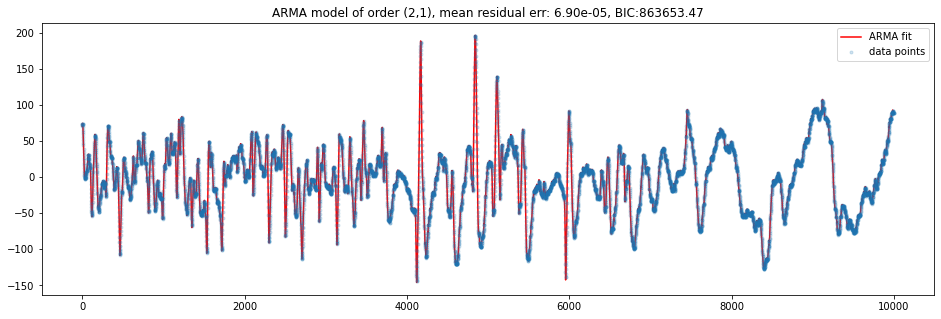

In [59]:
figure(figsize=(16,5))

plt.title('ARMA model of order (2,1), mean residual err: 6.90e-05, BIC:863653.47')
plt.plot(results.fittedvalues[110000:120000], color='red', label='ARMA fit')
plt.plot(data_cut[110000:120000,34], '.',alpha=0.2, label='data points')
legend()

# Granger causality
I used the result from the pervious assignment to choose channels that I would investigate with Granger causality test. Channels 8 and 1, also channels 23 and 15 were highly correlated during the whole recording, while channels 4 and 34 correlated much during the seizure, but less before and after it. These are the channel pairs I choose to test.\
I used the built-in function grangercausalitytests() of statsmodels. First the data had to transformed into the format the function requires.\
When we use this function we have to pay attention that the null hypothesis is that the there is no Granger causality between  the time series. This hypothesis can be rejected if the p values are small (or under a desired value)\


In [7]:
?grangercausalitytests()

In [7]:
data_cut[:10,1]

array([-4, -5, -4, -4, -4, -3, -1,  3,  8, 12], dtype=int16)

In [8]:
data_cut[:10,8]

array([-10, -11, -12, -12, -12, -10,  -9,  -7,  -5,  -4], dtype=int16)

In [9]:
#checking the format 
x_8cause1= np.array([data_cut[:,1],data_cut[:,8]]).T
x_8cause1

array([[ -4, -10],
       [ -5, -11],
       [ -4, -12],
       ...,
       [ 25, -13],
       [ 24, -14],
       [ 24, -15]], dtype=int16)

In [10]:
x_1cause8= np.array([data_cut[:,8],data_cut[:,1]]).T
x_1cause8

array([[-10,  -4],
       [-11,  -5],
       [-12,  -4],
       ...,
       [-13,  25],
       [-14,  24],
       [-15,  24]], dtype=int16)

Test: channel 8 cause 1

In [11]:
test8_1=grangercausalitytests(x_8cause1,[100],verbose=True)


Granger Causality
number of lags (no zero) 100
ssr based F test:         F=87.0998 , p=0.0000  , df_denom=226003, df_num=100
ssr based chi2 test:   chi2=8717.7262, p=0.0000  , df=100
likelihood ratio test: chi2=8553.9340, p=0.0000  , df=100
parameter F test:         F=87.0998 , p=0.0000  , df_denom=226003, df_num=100


Test the other way around: 1 cause 8

In [12]:
test1_8=grangercausalitytests(x_1cause8,[100],verbose=True)


Granger Causality
number of lags (no zero) 100
ssr based F test:         F=71.4483 , p=0.0000  , df_denom=226003, df_num=100
ssr based chi2 test:   chi2=7151.1851, p=0.0000  , df=100
likelihood ratio test: chi2=7040.4741, p=0.0000  , df=100
parameter F test:         F=71.4483 , p=0.0000  , df_denom=226003, df_num=100


For comparison I checked the Granger causality that were not correlated according to the results of the previous assignment.

In [13]:
x_7cause27= np.array([data_cut[:,27],data_cut[:,7]]).T
test7_27=grangercausalitytests(x_7cause27,[100],verbose=True)
test7_27


Granger Causality
number of lags (no zero) 100
ssr based F test:         F=14.7195 , p=0.0000  , df_denom=226003, df_num=100
ssr based chi2 test:   chi2=1473.2560, p=0.0000  , df=100
likelihood ratio test: chi2=1468.4791, p=0.0000  , df=100
parameter F test:         F=14.7195 , p=0.0000  , df_denom=226003, df_num=100


{100: ({'lrtest': (1468.479122370598, 6.247506956318392e-242, 100),
   'params_ftest': (14.719469125062112,
    9.902217309752527e-242,
    226003.0,
    100.0),
   'ssr_chi2test': (1473.2560160464689, 6.720924043951764e-243, 100),
   'ssr_ftest': (14.71946912497348, 9.90221735048673e-242, 226003.0, 100)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

As we van see, the p value is numerically 0 in the case of correlated channels, and very small (10 to the -125) in the case of seemingly not correlated channels. The smaller the p value, the stronger the evidence against our null hypothesis that there is no Granger causality between the channels.
This is a very strange result, I would expect non 0 p values.

 I choose a quite large lag between the data sets (100 data points). Since the sampling rate was 1000Hz, this means that we try to predict the values of a channel from recoirdings of on other channel that happened 1/10s before.\
I did run the test for smaller lags (4 and 10) but I got the same results: very small p values. Bigger lags caused crashing of the program. 

Below I try to compare the causality between channels 4 and 34 in the three periods: before, during and after seizure.

In [14]:
x_4cause34= np.array([before[:,34],before[:,4]]).T
test4_34=grangercausalitytests(x_4cause34,[100],verbose=True)
test4_34


Granger Causality
number of lags (no zero) 100
ssr based F test:         F=24.5978 , p=0.0000  , df_denom=74699, df_num=100
ssr based chi2 test:   chi2=2466.3945, p=0.0000  , df=100
likelihood ratio test: chi2=2426.6563, p=0.0000  , df=100
parameter F test:         F=24.5978 , p=0.0000  , df_denom=74699, df_num=100


{100: ({'lrtest': (2426.656333903811, 0.0, 100),
   'params_ftest': (24.597757174520375, 0.0, 74699.0, 100.0),
   'ssr_chi2test': (2466.3944796738756, 0.0, 100),
   'ssr_ftest': (24.597757174520538, 0.0, 74699.0, 100)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

In [15]:
x_4cause34_s= np.array([seizure[:,34],seizure[:,4]]).T
test4_34_s=grangercausalitytests(x_4cause34_s,[100],verbose=True)
test4_34_s


Granger Causality
number of lags (no zero) 100
ssr based F test:         F=26.4839 , p=0.0000  , df_denom=44699, df_num=100
ssr based chi2 test:   chi2=2660.3007, p=0.0000  , df=100
likelihood ratio test: chi2=2584.4709, p=0.0000  , df=100
parameter F test:         F=26.4839 , p=0.0000  , df_denom=44699, df_num=100


{100: ({'lrtest': (2584.470911294862, 0.0, 100),
   'params_ftest': (26.483915477193094, 0.0, 44699.0, 100.0),
   'ssr_chi2test': (2660.300688887682, 0.0, 100),
   'ssr_ftest': (26.48391547719165, 0.0, 44699.0, 100)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

In [16]:
x_4cause34_a= np.array([after[:,34],after[:,4]]).T
test4_34_a=grangercausalitytests(x_4cause34_a,[100],verbose=True)
test4_34_a


Granger Causality
number of lags (no zero) 100
ssr based F test:         F=22.7123 , p=0.0000  , df_denom=106003, df_num=100
ssr based chi2 test:   chi2=2275.5340, p=0.0000  , df=100
likelihood ratio test: chi2=2251.4989, p=0.0000  , df=100
parameter F test:         F=22.7123 , p=0.0000  , df_denom=106003, df_num=100


{100: ({'lrtest': (2251.4988559767953, 0.0, 100),
   'params_ftest': (22.712273754057083, 0.0, 106003.0, 100.0),
   'ssr_chi2test': (2275.534014863775, 0.0, 100),
   'ssr_ftest': (22.712273754058675, 0.0, 106003.0, 100)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

Unfortunately the p values are numerical zeros this time as well. It would have been nice to plot the p values, see how it changes in time and compare the causality between different channels. With these result it does noit make sense to do that of course.

The results suggest that there is very strong causality between the channels, however the fact that the p values are numerical zeros is very suspicious. I do not think these result are adequate. I suspect there is an error somewhere, maybe I use the grangercausalitytest() function inapproriately, but I could not find my mistake.



